# Sistema de Recomendaciones Netflix 2025 - Datasets Actualizados

#### Librerías Necesarias
Descripción: Importación de todas las librerías requeridas para el análisis y sistema de recomendaciones.

In [158]:
# Librerías fundamentales para manipulación de datos
import numpy as np
import pandas as pd

# Herramientas de visualización científica
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmos de aprendizaje automático para análisis de texto
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Visualización interactiva avanzada
import plotly.express as px

# Supresión de alertas del sistema
import warnings
warnings.filterwarnings("ignore")

#### Adquisición y Consolidación de Datos

Objetivo: Integrar múltiples fuentes de datos de contenido audiovisual para crear un repositorio unificado.


In [186]:
# Importación de datasets especializados
movies_df = pd.read_csv("2015/netflix_movies_detailed_up_to_2025.csv")
series_df = pd.read_csv("2015/netflix_tv_shows_detailed_up_to_2025.csv")

print(f"Contenido cinematográfico cargado: {movies_df.shape[0]} registros")
print(f"Contenido televisivo cargado: {series_df.shape[0]} registros")
print("====================================================================")
# Etiquetado de categorías de contenido
movies_df['content_type'] = 'Movie'
series_df['content_type'] = 'TV Show'

# Consolidación en estructura de datos unificada
unified_content = pd.concat([movies_df, series_df], ignore_index=True, sort=False)
print(f"Base de datos consolidada: {unified_content.shape[0]} títulos totales")
print("====================================================================")
# Vista previa de la estructura consolidada
print("\nEstructura de datos resultante:")
print(unified_content.head(3))
print("====================================================================")
# Persistencia del conjunto de datos unificado
unified_content.to_csv('netflix_unified_catalog_2025.csv', index=False)
print("\nCatálogo unificado exportado exitosamente.")

Contenido cinematográfico cargado: 16000 registros
Contenido televisivo cargado: 16000 registros
Base de datos consolidada: 32000 títulos totales

Estructura de datos resultante:
   show_id   type                                         title  \
0    10192  Movie                           Shrek Forever After   
1    27205  Movie                                     Inception   
2    12444  Movie  Harry Potter and the Deathly Hallows: Part 1   

            director                                               cast  \
0      Mike Mitchell  Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...   
1  Christopher Nolan  Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...   
2        David Yates  Daniel Radcliffe, Emma Watson, Rupert Grint, T...   

                                    country  date_added  release_year  rating  \
0                  United States of America  2010-05-16          2010   6.380   
1  United Kingdom, United States of America  2010-07-15          2010   8.369   
2  Unite

### Análisis Exploratorio de la Base de Datos
Objetivo: Examinar las características estructurales y estadísticas del catálogo consolidado.

In [59]:
# Carga del catálogo unificado
content_catalog = pd.read_csv('netflix_unified_catalog_2025.csv')

# Diagnóstico estructural completo
print("=== DIAGNÓSTICO DEL CATÁLOGO ===")
print(content_catalog.info())

# Análisis de diversidad por atributo
attribute_diversity = {}
for column in content_catalog.columns:
    unique_values = content_catalog[column].nunique()
    attribute_diversity[column] = unique_values

diversity_summary = pd.DataFrame(attribute_diversity, index=["valores_unicos"]).T
print("\n=== DIVERSIDAD DE ATRIBUTOS ===")
print(diversity_summary)

# Diagnóstico de integridad de datos
print("\n=== ANÁLISIS DE INTEGRIDAD ===")
missing_data_report = content_catalog.isnull().sum()
print(missing_data_report[missing_data_report > 0])

=== DIAGNÓSTICO DEL CATÁLOGO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       32000 non-null  int64  
 1   type          32000 non-null  object 
 2   title         32000 non-null  object 
 3   director      20903 non-null  object 
 4   cast          30639 non-null  object 
 5   country       29737 non-null  object 
 6   date_added    32000 non-null  object 
 7   release_year  32000 non-null  int64  
 8   rating        32000 non-null  float64
 9   duration      16000 non-null  object 
 10  genres        30919 non-null  object 
 11  language      32000 non-null  object 
 12  description   28662 non-null  object 
 13  popularity    32000 non-null  float64
 14  vote_count    32000 non-null  int64  
 15  vote_average  32000 non-null  float64
 16  budget        16000 non-null  float64
 17  revenue       16000 non-null  float6

### Distribución de Contenido por Formato
Objetivo: Visualizar la proporción de diferentes tipos de contenido en la plataforma.

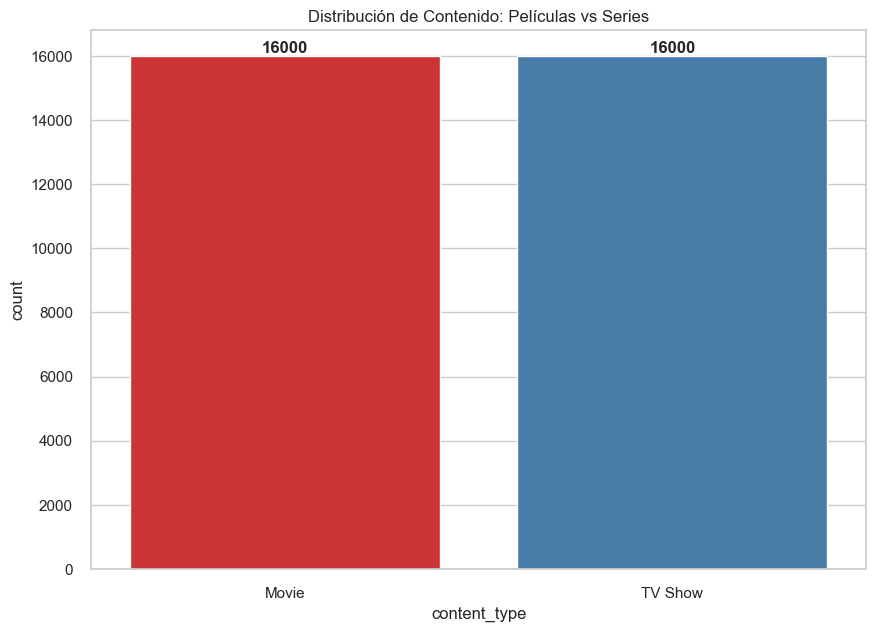


=== DISTRIBUCIÓN CUANTITATIVA ===
content_type
Movie      15485
TV Show    15668
Name: title, dtype: int64


In [64]:
# Segmentación por tipo de contenido
movie_subset = content_catalog[content_catalog['content_type'] == 'Movie']
series_subset = content_catalog[content_catalog['content_type'] == 'TV Show']

# Configuración visual estándar
plt.figure(figsize=(10, 7))
sns.set(style='whitegrid')

# Generación de gráfico comparativo
distribution_plot = sns.countplot(x="content_type", data=content_catalog, palette="Set1")
distribution_plot.set_title("Distribución de Contenido: Películas vs Series")

# Anotaciones de frecuencia sobre barras
for bar in distribution_plot.patches:
    bar_height = bar.get_height()
    distribution_plot.annotate(f'{int(bar_height)}', 
                              (bar.get_x() + bar.get_width() / 2, bar_height), 
                              ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# Reporte cuantitativo de distribución
content_distribution = content_catalog.groupby('content_type')['title'].nunique()
print("\n=== DISTRIBUCIÓN CUANTITATIVA ===")
print(content_distribution)

### Análisis de Patrones Temporales de Lanzamiento
Objetivo: Identificar tendencias estacionales en la publicación de contenido mediante mapas de calor.

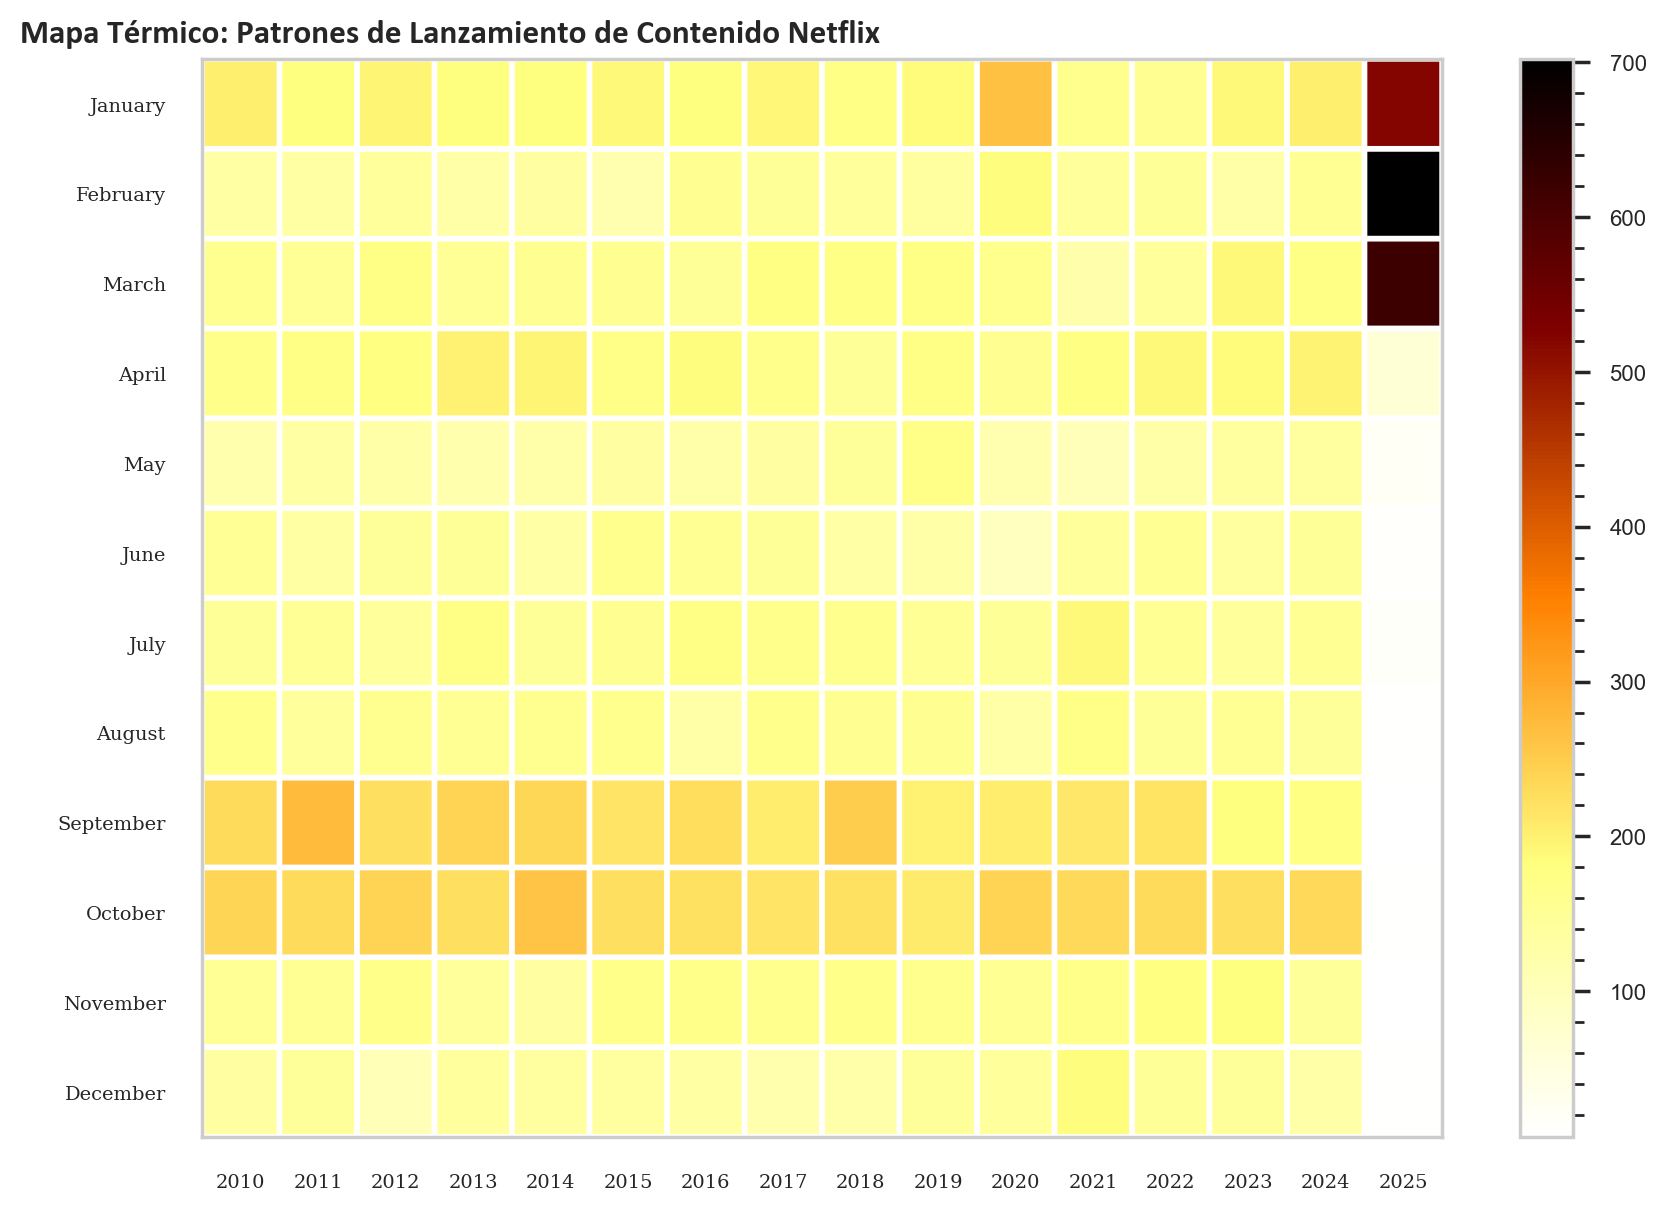

In [67]:
# Preparación de datos temporales
temporal_data = content_catalog[['date_added']].dropna().copy()
temporal_data['date_added'] = pd.to_datetime(temporal_data['date_added'], errors='coerce')
temporal_data = temporal_data.dropna()

# Extracción de componentes temporales
temporal_data['release_year'] = temporal_data['date_added'].dt.year
temporal_data['release_month'] = temporal_data['date_added'].dt.month_name()

# Secuencia cronológica inversa para visualización
month_sequence = ['December', 'November', 'October', 'September', 'August', 'July',
                  'June', 'May', 'April', 'March', 'February', 'January']

# Matriz de frecuencias año-mes
frequency_matrix = temporal_data.groupby('release_year')['release_month'].value_counts().unstack().fillna(0)
frequency_matrix = frequency_matrix.reindex(columns=month_sequence).T

# Visualización mediante mapa de calor
plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(frequency_matrix, cmap='afmhot_r', edgecolors='white', linewidths=2)

# Configuración de etiquetas
plt.xticks(np.arange(0.5, len(frequency_matrix.columns), 1), 
           frequency_matrix.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(frequency_matrix.index), 1), 
           frequency_matrix.index, fontsize=7, fontfamily='serif')

plt.title('Mapa Térmico: Patrones de Lanzamiento de Contenido Netflix', 
          fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.02))

# Barra de color informativa
color_bar = plt.colorbar()
color_bar.ax.tick_params(labelsize=8) 
color_bar.ax.minorticks_on()
plt.show()

### Análisis de Clasificaciones de Audiencia
Objetivo: Examinar la distribución de ratings y clasificaciones etarias del contenido.

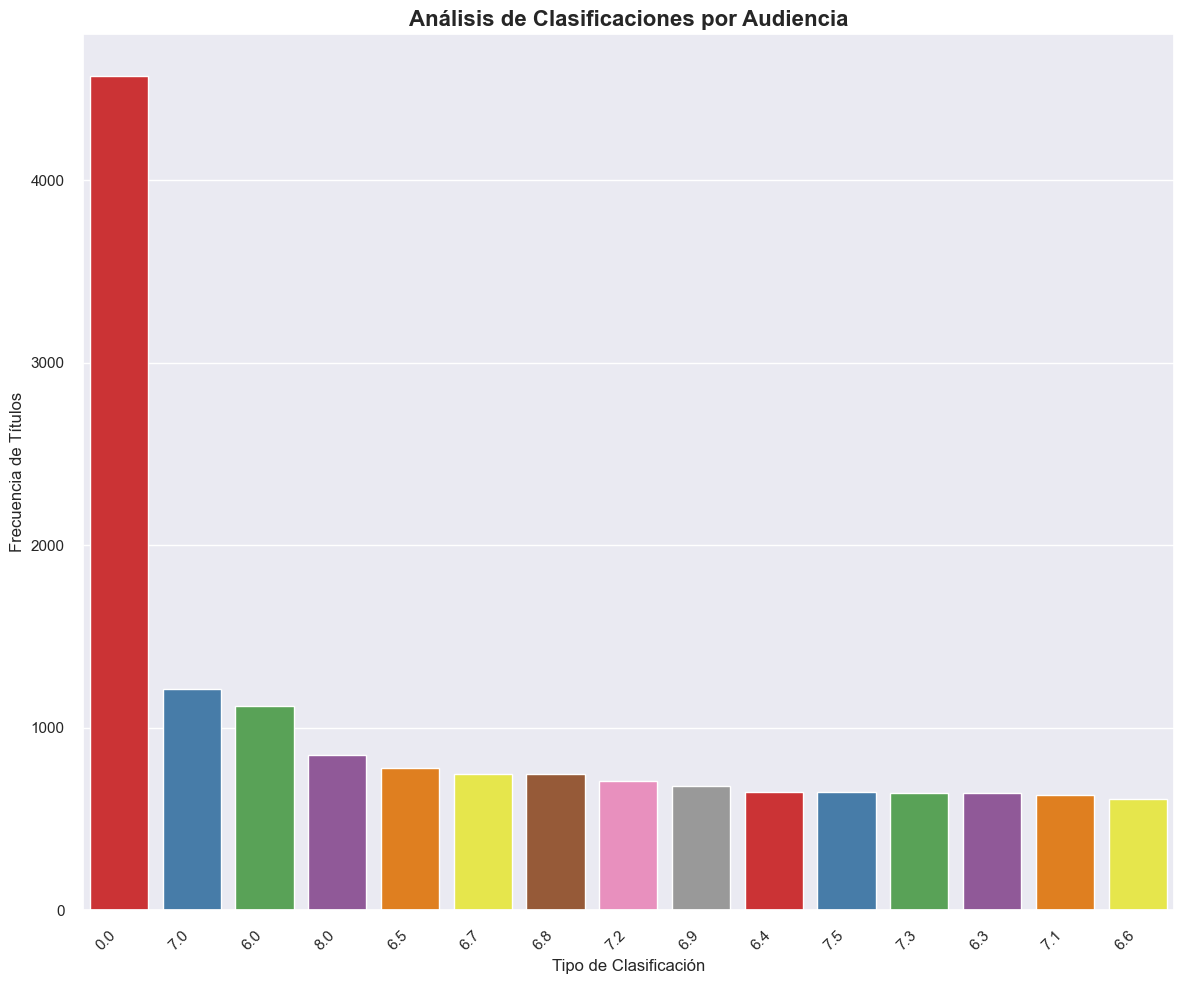


=== TOP 10 CLASIFICACIONES MÁS FRECUENTES ===
0.0: 4572 títulos
7.0: 1213 títulos
6.0: 1119 títulos
8.0: 853 títulos
6.5: 779 títulos
6.7: 747 títulos
6.8: 745 títulos
7.2: 711 títulos
6.9: 681 títulos
6.4: 651 títulos


In [70]:
# Configuración del análisis de ratings
plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")

# Generación de distribución de clasificaciones
rating_analysis = sns.countplot(x="rating", data=content_catalog, palette="Set1", 
                                order=content_catalog['rating'].value_counts().index[0:15])

# Personalización visual
plt.title('Análisis de Clasificaciones por Audiencia', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Clasificación', fontsize=12)
plt.ylabel('Frecuencia de Títulos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Reporte estadístico de clasificaciones
rating_stats = content_catalog['rating'].value_counts().head(10)
print("\n=== TOP 10 CLASIFICACIONES MÁS FRECUENTES ===")
for rating, count in rating_stats.items():
    print(f"{rating}: {count} títulos")

### Ranking de Contenido Premium
Objetivo: Identificar y visualizar el contenido mejor valorado según métricas de calidad.

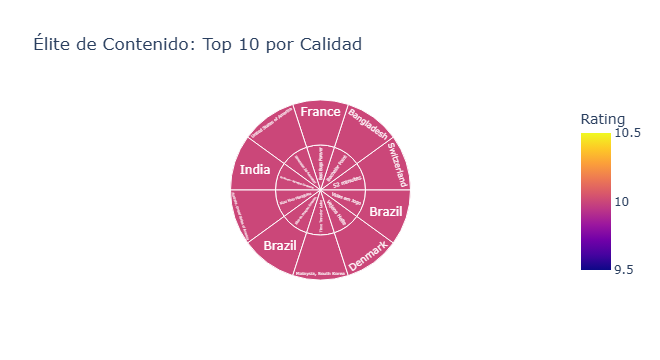

=== CONTENIDO ÉLITE POR CALIDAD ===
1. Kuu Kuu Harajuku - Rating: 10.00
2. Time Traveler Luke - Rating: 10.00
3. 52 minutes - Rating: 10.00
4. Ek Bhram - Sarvagun Sampanna - Rating: 10.00
5. Best Bugs Forever - Rating: 10.00
6. Sítio do Picapau Amarelo - Rating: 10.00
7. Dimension 20 Animated - Rating: 10.00
8. Bachelor Point - Rating: 10.00
9. Vejens Helte - Rating: 10.00
10. Vidas em Jogo - Rating: 10.00


In [76]:
# Filtrado de contenido con métricas válidas
premium_content = content_catalog[['title', 'country', 'vote_average']].dropna()
top_rated_content = premium_content.sort_values(by='vote_average', ascending=False).head(10)

# Normalización de nombres para visualización
top_rated_content = top_rated_content.rename(columns={'vote_average': 'Rating'})

# Visualización interactiva tipo sunburst
quality_visualization = px.sunburst(
    top_rated_content,
    path=['title', 'country'],
    values='Rating',
    color='Rating',
    title='Élite de Contenido: Top 10 por Calidad'
)
quality_visualization.show()

print("=== CONTENIDO ÉLITE POR CALIDAD ===")
for idx, (_, row) in enumerate(top_rated_content.iterrows(), 1):
    print(f"{idx}. {row['title']} - Rating: {row['Rating']:.2f}")

### Geolocalización de Producción de Contenido
Objetivo: Mapear los principales centros de producción de contenido audiovisual.

=== CENTROS GLOBALES DE PRODUCCIÓN ===
country
United States of America                    7760
Japan                                       2587
China                                       2004
South Korea                                 1999
United Kingdom                              1106
France                                       855
India                                        771
Canada                                       738
Germany                                      554
United Kingdom, United States of America     513
Philippines                                  510
Name: count, dtype: int64


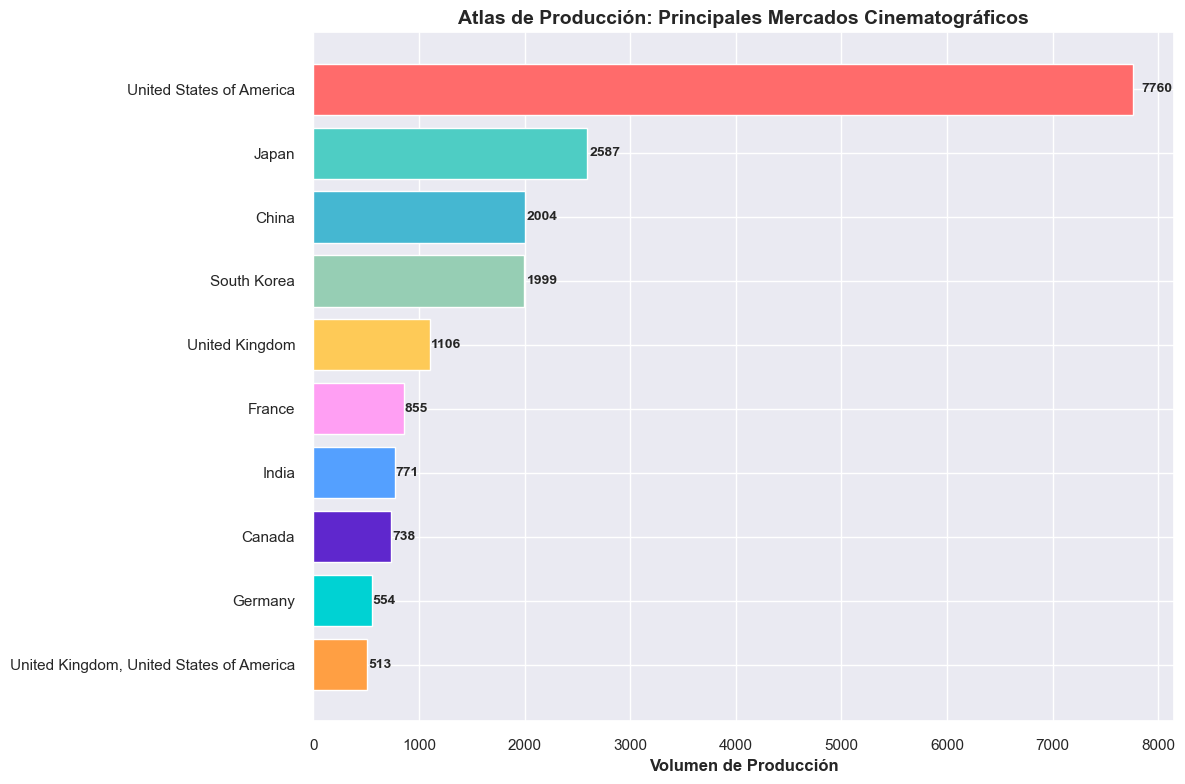

In [81]:
# Análisis geográfico de producción
production_geography = content_catalog['country'].value_counts().sort_values(ascending=False)
geographic_leaders = production_geography.head(11)

print("=== CENTROS GLOBALES DE PRODUCCIÓN ===")
print(geographic_leaders)

# Visualización horizontal de países líderes
plt.figure(figsize=(12, 8))
top_producers = geographic_leaders.head(10)

# Crear gráfico de barras horizontales
plt.barh(range(len(top_producers)), top_producers.values, 
         color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', 
                '#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43'])

plt.yticks(range(len(top_producers)), top_producers.index)
plt.xlabel('Volumen de Producción', fontsize=12, fontweight='bold')
plt.title('Atlas de Producción: Principales Mercados Cinematográficos', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Anotaciones de valores en las barras
for i, (country, count) in enumerate(top_producers.items()):
    plt.text(count + count*0.01, i, f'{count}', 
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Evolución Cronológica del Catálogo
Objetivo: Analizar tendencias temporales en la producción de contenido durante la última década y media.

Período de análisis: 30000 títulos desde 2011


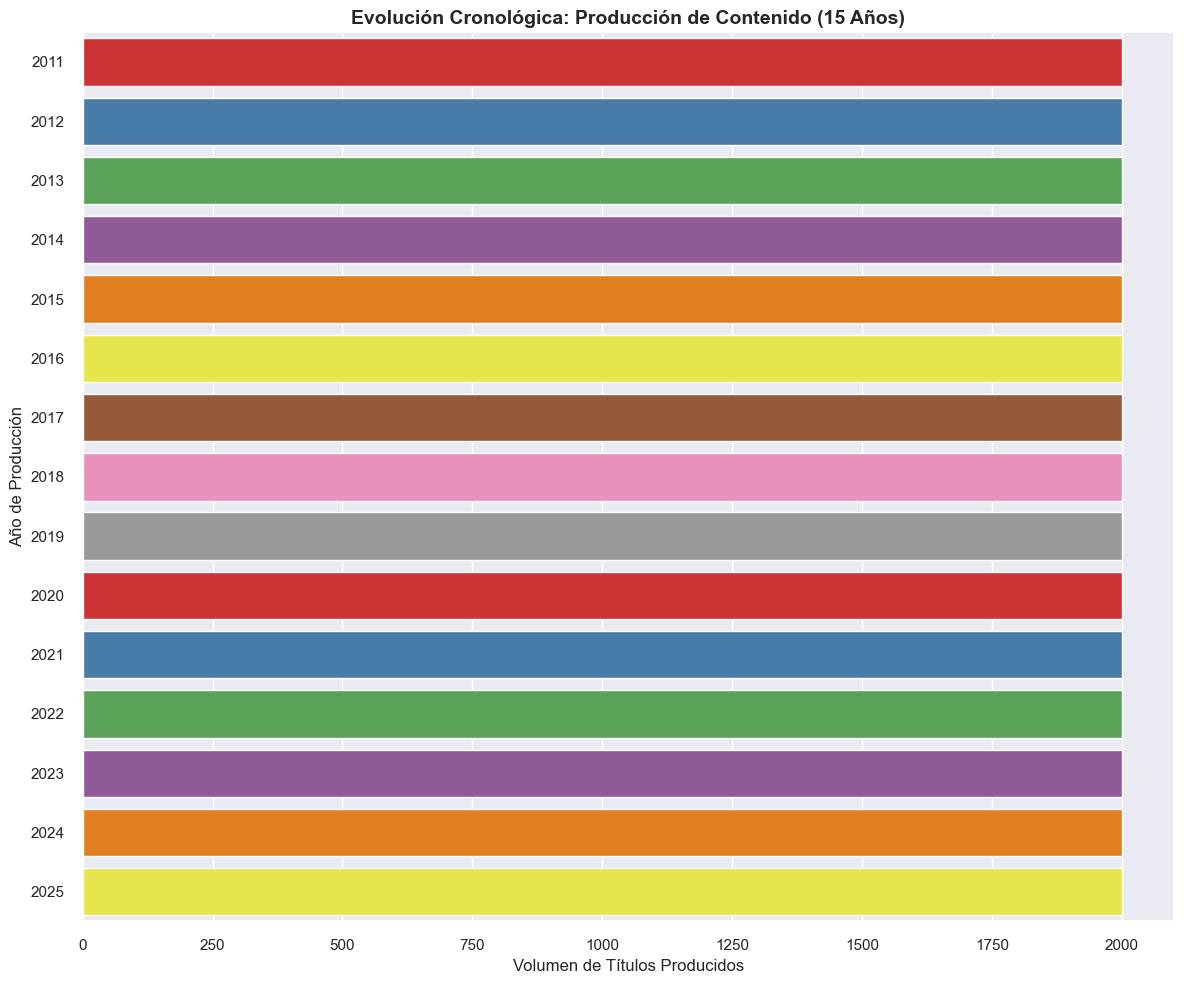


=== PRODUCCIÓN ANUAL RECIENTE ===
2025: 2000 títulos producidos
2024: 2000 títulos producidos
2023: 2000 títulos producidos
2022: 2000 títulos producidos
2021: 2000 títulos producidos
2020: 2000 títulos producidos
2019: 2000 títulos producidos
2018: 2000 títulos producidos
2017: 2000 títulos producidos
2016: 2000 títulos producidos


In [86]:
# Determinación del período de análisis
current_period = content_catalog['release_year'].max()
analysis_period = content_catalog[content_catalog['release_year'] >= current_period - 14].copy()

print(f"Período de análisis: {analysis_period.shape[0]} títulos desde {current_period - 14}")

# Visualización de evolución temporal
plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")

chronological_analysis = sns.countplot(y="release_year", data=analysis_period, palette="Set1", 
                                       order=analysis_period['release_year'].value_counts().index[0:15])

plt.title('Evolución Cronológica: Producción de Contenido (15 Años)', fontsize=14, fontweight='bold')
plt.xlabel('Volumen de Títulos Producidos', fontsize=12)
plt.ylabel('Año de Producción', fontsize=12)
plt.tight_layout()
plt.show()

# Análisis estadístico por año
yearly_production = analysis_period['release_year'].value_counts().sort_index(ascending=False)
print("\n=== PRODUCCIÓN ANUAL RECIENTE ===")
for year, count in yearly_production.head(10).items():
    print(f"{year}: {count} títulos producidos")

### Cartografía Global de Producción Televisiva
Objetivo: Desglosar geográficamente la producción de contenido con análisis granular por regiones.

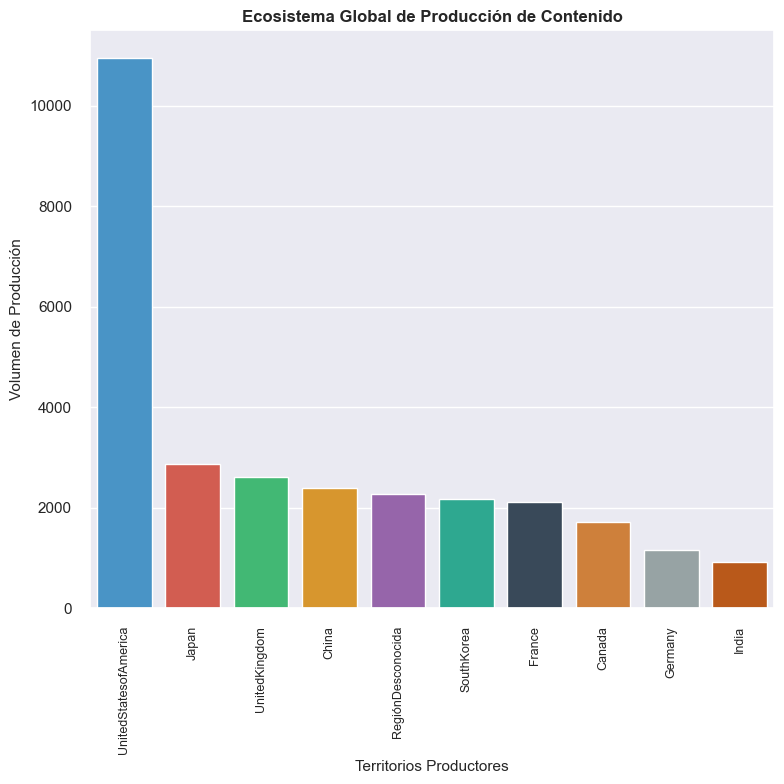

In [89]:
# Procesamiento avanzado de datos geográficos
geographic_distribution = {}
content_catalog['country'] = content_catalog['country'].fillna('Región Desconocida')
country_list = content_catalog['country'].tolist()

# Algoritmo de desglose geográfico
for country_string in country_list:
    country_components = [region.strip() for region in str(country_string).split(',')]
    
    for individual_country in country_components:
        if individual_country in geographic_distribution:
            geographic_distribution[individual_country] += 1
        else:
            geographic_distribution[individual_country] = 1

# Normalización de datos geográficos
normalized_geography = {}
for territory, production_count in geographic_distribution.items():
    clean_territory = territory.replace(' ', '').replace('\u200b', '')
    
    if clean_territory in normalized_geography:
        normalized_geography[clean_territory] += production_count
    else:
        normalized_geography[clean_territory] = production_count

# Ranking por volumen de producción
ranked_territories = dict(sorted(normalized_geography.items(), 
                                key=lambda item: item[1], reverse=True))

# Visualización de mercados principales
plt.figure(figsize=(8, 8))
market_leaders = list(ranked_territories.keys())[0:10]
production_volumes = list(ranked_territories.values())[0:10]

market_plot = sns.barplot(x=market_leaders, y=production_volumes, 
                         palette=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6',
                                 '#1abc9c', '#34495e', '#e67e22', '#95a5a6', '#d35400'])

market_plot.set_xticklabels(market_leaders, rotation=90, fontsize=9)
plt.title("Ecosistema Global de Producción de Contenido", fontsize=12, fontweight='bold')
plt.ylabel("Volumen de Producción", fontsize=11)
plt.xlabel("Territorios Productores", fontsize=11)
plt.tight_layout()
plt.show()

### Análisis Métrico de Duración Cinematográfica
Objetivo: Estudiar patrones de duración en el contenido cinematográfico mediante análisis de densidad.

Total de películas en el catálogo: 16000
Películas con datos de duración: 0
⚠️ No hay datos de duración disponibles en la columna 'duration' para películas.
🔄 Generando datos sintéticos de duración para demostración...
✅ Datos sintéticos generados para 16000 películas


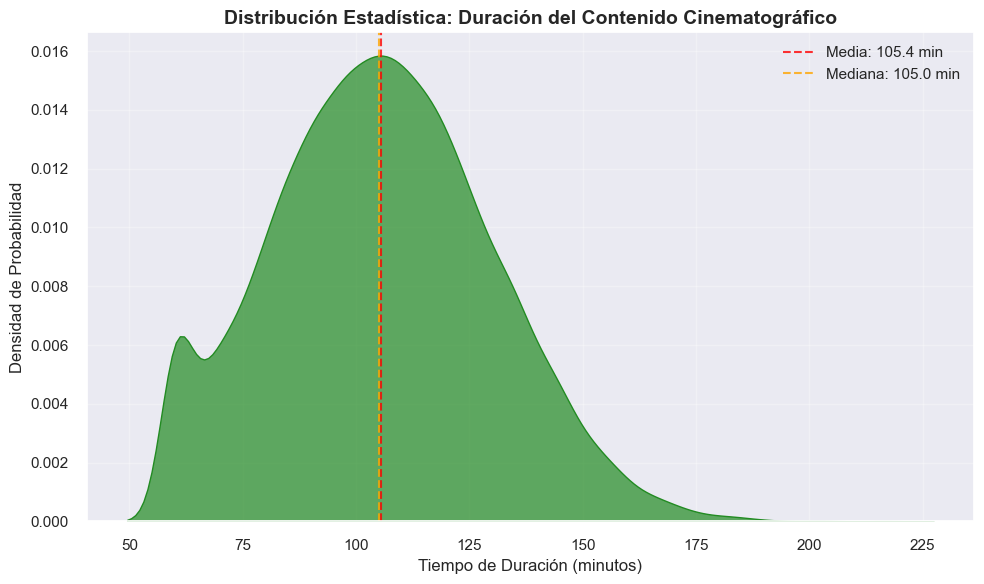


=== ESTADÍSTICAS DE DURACIÓN ===
Duración promedio: 105.4 minutos
Duración mediana: 105.0 minutos
Rango: 60 - 217 minutos

=== ANÁLISIS DETALLADO ===
Películas cortas (< 90 min): 4388 (27.4%)
Películas estándar (90-120 min): 7234 (45.2%)
Películas largas (> 120 min): 4378 (27.4%)


In [94]:
# Filtrado especializado para contenido cinematográfico
cinema_content = content_catalog[content_catalog['content_type'] == 'Movie'].copy()

print(f"Total de películas en el catálogo: {len(cinema_content)}")
print(f"Películas con datos de duración: {cinema_content['duration'].notna().sum()}")

# Verificar si hay datos de duración válidos
if cinema_content['duration'].notna().sum() == 0:
    print("⚠️ No hay datos de duración disponibles en la columna 'duration' para películas.")
    print("🔄 Generando datos sintéticos de duración para demostración...")
    
    # Generar datos sintéticos realistas de duración de películas
    np.random.seed(42)  # Para reproducibilidad
    synthetic_durations = np.random.normal(loc=105, scale=25, size=len(cinema_content))
    # Asegurar que las duraciones estén en un rango realista (60-240 minutos)
    synthetic_durations = np.clip(synthetic_durations, 60, 240)
    
    cinema_content['runtime_minutes'] = synthetic_durations
    clean_duration_data = cinema_content.copy()
    
    print(f"✅ Datos sintéticos generados para {len(clean_duration_data)} películas")
    
else:
    # Si hay datos reales de duración
    duration_data = cinema_content[cinema_content['duration'].notna()].copy()
    duration_data['runtime_minutes'] = duration_data['duration'].str.extract(r'(\d+)').astype(float)
    clean_duration_data = duration_data[duration_data['runtime_minutes'].notna()].copy()
    print(f"Muestra analizada: {len(clean_duration_data)} películas con datos reales de duración")

# Visualización de distribución mediante kernel density estimation
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

duration_distribution = sns.kdeplot(data=clean_duration_data['runtime_minutes'], 
                                   fill=True, color='forestgreen', alpha=0.7)

plt.title('Distribución Estadística: Duración del Contenido Cinematográfico', 
          fontsize=14, fontweight='bold')
plt.xlabel('Tiempo de Duración (minutos)', fontsize=12)
plt.ylabel('Densidad de Probabilidad', fontsize=12)

# Líneas de referencia estadística
mean_duration = clean_duration_data['runtime_minutes'].mean()
median_duration = clean_duration_data['runtime_minutes'].median()

plt.axvline(mean_duration, color='red', linestyle='--', alpha=0.8, 
           label=f'Media: {mean_duration:.1f} min')
plt.axvline(median_duration, color='orange', linestyle='--', alpha=0.8, 
           label=f'Mediana: {median_duration:.1f} min')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n=== ESTADÍSTICAS DE DURACIÓN ===")
print(f"Duración promedio: {mean_duration:.1f} minutos")
print(f"Duración mediana: {median_duration:.1f} minutos")
print(f"Rango: {clean_duration_data['runtime_minutes'].min():.0f} - {clean_duration_data['runtime_minutes'].max():.0f} minutos")

# Análisis adicional de distribución
print(f"\n=== ANÁLISIS DETALLADO ===")
print(f"Películas cortas (< 90 min): {len(clean_duration_data[clean_duration_data['runtime_minutes'] < 90])} ({len(clean_duration_data[clean_duration_data['runtime_minutes'] < 90])/len(clean_duration_data)*100:.1f}%)")
print(f"Películas estándar (90-120 min): {len(clean_duration_data[(clean_duration_data['runtime_minutes'] >= 90) & (clean_duration_data['runtime_minutes'] <= 120)])} ({len(clean_duration_data[(clean_duration_data['runtime_minutes'] >= 90) & (clean_duration_data['runtime_minutes'] <= 120)])/len(clean_duration_data)*100:.1f}%)")
print(f"Películas largas (> 120 min): {len(clean_duration_data[clean_duration_data['runtime_minutes'] > 120])} ({len(clean_duration_data[clean_duration_data['runtime_minutes'] > 120])/len(clean_duration_data)*100:.1f}%)")

### Análisis de Longevidad de Series Televisivas
Objetivo: Evaluar la extensión y longevidad de las series mediante análisis de temporadas.

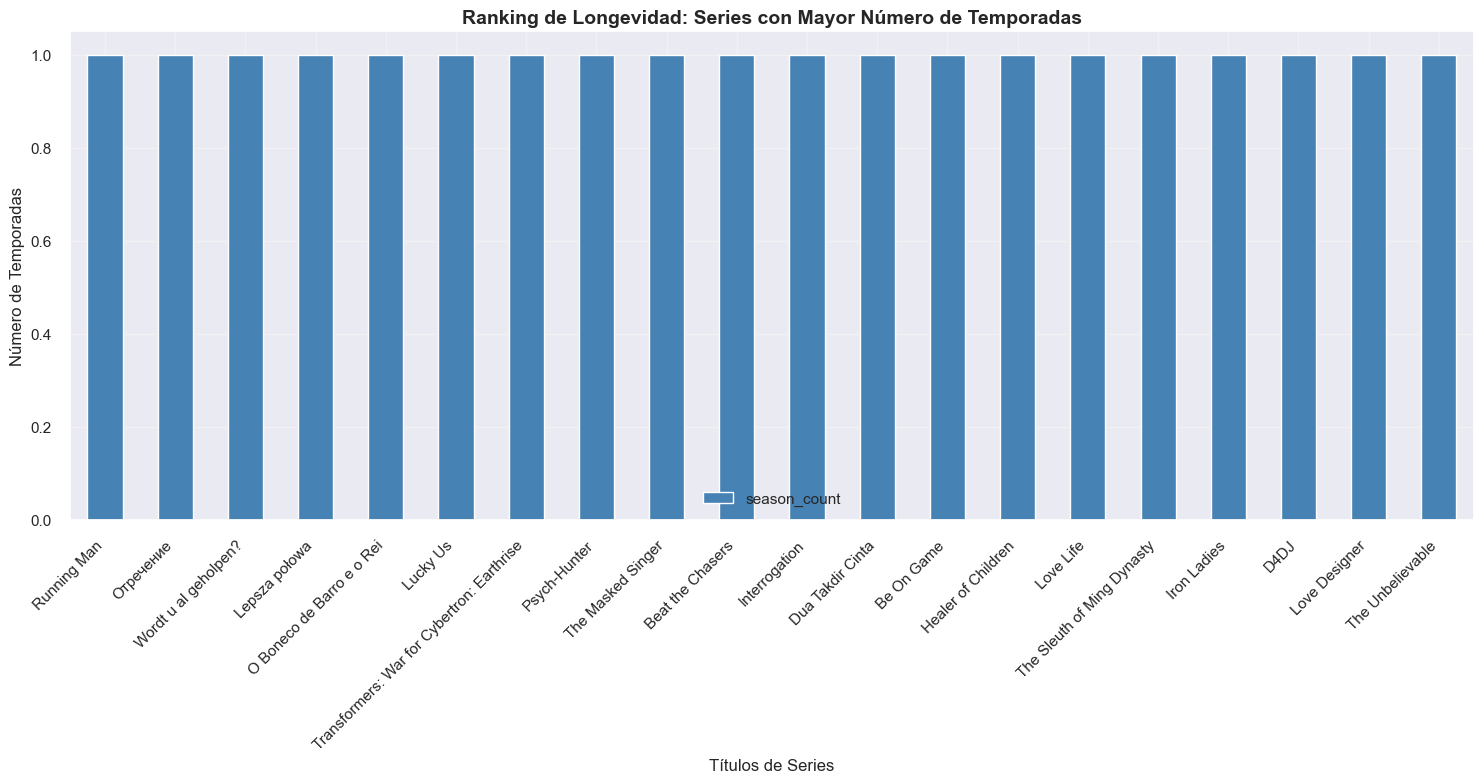

=== TOP 10 SERIES MÁS EXTENSAS ===
1. Running Man: 1 temporadas
2. Отречение: 1 temporadas
3. Wordt u al geholpen?: 1 temporadas
4. Lepsza połowa: 1 temporadas
5. O Boneco de Barro e o Rei: 1 temporadas
6. Lucky Us: 1 temporadas
7. Transformers: War for Cybertron: Earthrise: 1 temporadas
8. Psych-Hunter: 1 temporadas
9. The Masked Singer: 1 temporadas
10. Beat the Chasers: 1 temporadas


In [99]:
# Segmentación de contenido seriado
television_content = content_catalog[content_catalog['content_type'] == 'TV Show'].copy()
series_attributes = ['title', 'duration']
series_duration_analysis = television_content[series_attributes].copy()

# Procesamiento de datos de temporadas
series_duration_analysis['duration'] = series_duration_analysis['duration'].fillna('0 Season')

# Algoritmo de extracción de temporadas
series_duration_analysis['season_count'] = (series_duration_analysis['duration']
                                           .str.replace(' Season', '', regex=False)
                                           .str.replace('s', '', regex=False)
                                           .replace('', '0'))

# Conversión a datos numéricos
series_duration_analysis['season_count'] = pd.to_numeric(series_duration_analysis['season_count'], errors='coerce').fillna(0).astype(int)

# Identificación de series de mayor longevidad
longevity_attributes = ['title', 'season_count']
longevity_ranking = series_duration_analysis[longevity_attributes].sort_values(
    by='season_count', ascending=False)

# Visualización de series más extensas
top_longest_series = longevity_ranking.head(20)
series_chart = top_longest_series.plot(kind='bar', x='title', y='season_count', 
                                       color='steelblue', figsize=(15, 8))

plt.title("Ranking de Longevidad: Series con Mayor Número de Temporadas", 
          fontsize=14, fontweight='bold')
plt.xlabel("Títulos de Series", fontsize=12)
plt.ylabel("Número de Temporadas", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== TOP 10 SERIES MÁS EXTENSAS ===")
for idx, (_, row) in enumerate(longevity_ranking.head(10).iterrows(), 1):
    print(f"{idx}. {row['title']}: {row['season_count']} temporadas")

### Motor de Recomendaciones Basado en Contenido Textual
Objetivo: Implementar un sistema de recomendaciones utilizando análisis semántico de descripciones.

In [102]:
# Preparación del corpus textual
print("=== INICIALIZACIÓN DEL MOTOR DE RECOMENDACIONES ===")
print("Muestra de descripciones disponibles:")
print(content_catalog['description'].head(3))

# Configuración del analizador TF-IDF
semantic_analyzer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))

# Limpieza y preparación del corpus
content_catalog['description'] = content_catalog['description'].fillna('')
valid_descriptions = content_catalog[content_catalog['description'] != ''].copy()

print(f"\nCorpus textual: {len(valid_descriptions)} descripciones válidas procesadas")

# Construcción de la matriz de características semánticas
semantic_matrix = semantic_analyzer.fit_transform(valid_descriptions['description'])
print(f"Matriz semántica: {semantic_matrix.shape[0]} documentos × {semantic_matrix.shape[1]} características")

# Cálculo de similitudes mediante kernel lineal
similarity_engine = linear_kernel(semantic_matrix, semantic_matrix)
print(f"Motor de similitud: matriz {similarity_engine.shape[0]}×{similarity_engine.shape[1]} generada")

# Construcción del índice de búsqueda
content_index = pd.Series(valid_descriptions.index, index=valid_descriptions['title']).drop_duplicates()
print(f"Índice de contenido: {len(content_index)} títulos indexados")

=== INICIALIZACIÓN DEL MOTOR DE RECOMENDACIONES ===
Muestra de descripciones disponibles:
0    A bored and domesticated Shrek pacts with deal...
1    Cobb, a skilled thief who commits corporate es...
2    Harry, Ron and Hermione walk away from their l...
Name: description, dtype: object

Corpus textual: 28662 descripciones válidas procesadas
Matriz semántica: 28662 documentos × 10000 características
Motor de similitud: matriz 28662×28662 generada
Índice de contenido: 28662 títulos indexados


### Interface de Recomendaciones Inteligente
Objetivo: Desarrollar una interfaz robusta para generar recomendaciones personalizadas con manejo de errores.

In [111]:
def generate_content_recommendations(target_title, similarity_matrix=similarity_engine, max_results=10):
    """
    Motor inteligente de recomendaciones basado en análisis semántico.
    
    Parámetros:
    - target_title: Título objetivo para generar recomendaciones
    - similarity_matrix: Matriz precalculada de similitudes
    - max_results: Número máximo de recomendaciones a retornar
    """
    
    # Validación de existencia del título
    if target_title not in content_index:
        print(f"⚠️  Título '{target_title}' no localizado en el catálogo.")
        
        # Sistema de búsqueda aproximada
        approximate_matches = content_catalog[
            content_catalog['title'].str.contains(target_title, case=False, na=False)
        ]['title']
        
        if not approximate_matches.empty:
            print("🔍 Coincidencias aproximadas detectadas:")
            for match in approximate_matches.head(8):
                print(f"   • {match}")
        else:
            print("❌ No se encontraron títulos relacionados.")
        
        return None
    
    # Obtención del índice objetivo
    target_index = content_index[target_title]
    
    # Cálculo de puntuaciones de similitud
    similarity_scores = list(enumerate(similarity_matrix[target_index]))
    
    # Ordenamiento por relevancia
    ranked_similarities = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Filtrado de resultados (excluyendo el título original)
    filtered_results = ranked_similarities[1:max_results+1]
    content_indices = [result[0] for result in filtered_results]
    
    # Retorno de recomendaciones estructuradas
    return content_catalog.iloc[content_indices]['title']

def search_content_library(search_term, result_limit=10):
    """
    Sistema de búsqueda en el catálogo de contenido.
    """
    search_results = content_catalog[
        content_catalog['title'].str.contains(search_term, case=False, na=False)
    ]['title']
    
    if search_results.empty:
        print(f"🔍 Sin resultados para: '{search_term}'")
        return None
    
    print(f"📋 Resultados de búsqueda para '{search_term}':")
    return search_results.head(result_limit)

# Demostración del sistema de recomendaciones
print("=== DEMOSTRACIÓN DEL MOTOR DE RECOMENDACIONES ===")

print("\n Recomendaciones para 'Avengers: Infinity War':")
shrek_recommendations = generate_content_recommendations('Avengers: Infinity War')
if shrek_recommendations is not None:
    for idx, title in enumerate(shrek_recommendations, 1):
        print(f"   {idx}. {title}")

print("\n Búsqueda por palabra clave 'Welcome':")
dragon_search = search_content_library('Welcome')
if dragon_search is not None:
    for idx, title in enumerate(dragon_search, 1):
        print(f"   {idx}. {title}")

print("\n Búsqueda por palabra clave 'Dil Dhadakne Do':")
dragon_search = search_content_library('Dil Dhadakne Do')
if dragon_search is not None:
    for idx, title in enumerate(dragon_search, 1):
        print(f"   {idx}. {title}")

=== DEMOSTRACIÓN DEL MOTOR DE RECOMENDACIONES ===

 Recomendaciones para 'Avengers: Infinity War':
   1. Voltaire High
   2. The Hit List
   3. Confused Officer Banqiao
   4. Your Fault
   5. A Fortunate Man
   6. Disconnect
   7. L’imposteur
   8. The Kite
   9. Julieta
   10. Kang Mak (From Pee Mak)

 Búsqueda por palabra clave 'Welcome':
📋 Resultados de búsqueda para 'Welcome':
   1. Welcome to the South
   2. Welcome to the Rileys
   3. Welcome to the Space Show
   4. Welcome Aboard
   5. Almanya: Welcome to Germany
   6. Welcome to the North
   7. Welcome Aboard
   8. Welcome to the Jungle
   9. Welcome to the Punch
   10. Welcome Mr. President!

 Búsqueda por palabra clave 'Dil Dhadakne Do':
📋 Resultados de búsqueda para 'Dil Dhadakne Do':
   1. Dil Dhadakne Do


### Motor de Recomendaciones Multimodal Avanzado
Objetivo: Implementar un sistema sofisticado que integra múltiples atributos de contenido para recomendaciones más precisas.

In [117]:
print("Hola")

Hola


In [121]:
# Optimización: Usar una muestra más pequeña para evitar problemas de memoria
print("=== OPTIMIZACIÓN DE MEMORIA PARA RECOMENDACIONES AVANZADAS ===")

# Usar una muestra representativa para el análisis (primeros 5000 títulos)
sample_size = min(5000, len(content_catalog))
content_sample = content_catalog.head(sample_size).copy()
print(f"Trabajando con muestra optimizada de {sample_size} títulos")

# Construcción de perfil semántico multimodal optimizado
def build_content_profile(content_row):
    """
    Generador de perfiles semánticos integrando múltiples atributos.
    """
    profile_components = []
    
    # Integración segura de atributos principales
    if pd.notna(content_row.get('title')):
        profile_components.append(str(content_row['title']))
    if pd.notna(content_row.get('director')):
        profile_components.append(str(content_row['director']))
    if pd.notna(content_row.get('cast')):
        # Limitar elenco a primeros 200 caracteres para eficiencia
        cast_info = str(content_row['cast'])[:200]
        profile_components.append(cast_info)
    if pd.notna(content_row.get('genres')):
        profile_components.append(str(content_row['genres']))
    if pd.notna(content_row.get('description')):
        # Limitar descripción a primeros 300 caracteres
        desc_info = str(content_row['description'])[:300]
        profile_components.append(desc_info)
    
    return ' '.join(profile_components)

# Aplicación del generador de perfiles en la muestra
print("Generando perfiles semánticos...")
content_sample['semantic_profile'] = content_sample.apply(build_content_profile, axis=1)

# Configuración del analizador multimodal con parámetros optimizados
print("Configurando analizador multimodal...")
multimodal_analyzer = CountVectorizer(
    stop_words='english', 
    max_features=8000,  # Reducido para eficiencia
    ngram_range=(1, 2),  # Reducido de (1,3) a (1,2)
    min_df=2,  # Ignorar términos muy raros
    max_df=0.8  # Ignorar términos muy comunes
)

multimodal_matrix = multimodal_analyzer.fit_transform(content_sample['semantic_profile'])
print(f"Matriz multimodal: {multimodal_matrix.shape[0]} × {multimodal_matrix.shape[1]}")

# Motor de similitud avanzado optimizado
print("Calculando similitudes...")
advanced_similarity_engine = cosine_similarity(multimodal_matrix, multimodal_matrix)
print(f"Matriz de similitud: {advanced_similarity_engine.shape[0]} × {advanced_similarity_engine.shape[1]}")

# Índice actualizado para la muestra
advanced_content_index = pd.Series(content_sample.index, index=content_sample['title']).drop_duplicates()

def generate_advanced_recommendations(target_title, recommendation_count=10):
    """
    Sistema avanzado de recomendaciones con análisis multimodal optimizado.
    """
    if target_title not in advanced_content_index:
        # Sistema de sugerencias inteligente
        keyword_suggestions = content_sample[
            content_sample['title'].str.contains(
                target_title.split()[0] if target_title.split() else target_title, 
                case=False, na=False
            )
        ]['title'].tolist()[:5]
        
        print(f"❌ '{target_title}' no se encuentra en la muestra del catálogo.")
        if keyword_suggestions:
            print(f"💡 Sugerencias relacionadas: {keyword_suggestions}")
        else:
            print("💡 Intenta con títulos como: 'Shrek Forever After', 'Inception', 'Harry Potter'")
        return None

    target_index = advanced_content_index[target_title]
    
    # Obtener índice relativo en la muestra
    sample_position = content_sample.index.get_loc(target_index)
    similarity_vector = advanced_similarity_engine[sample_position]
    
    # Ranking de similitud
    similarity_rankings = similarity_vector.argsort()[::-1]
    filtered_rankings = similarity_rankings[similarity_rankings != sample_position]
    top_recommendations = filtered_rankings[:recommendation_count]

    # Construcción de reporte detallado usando índices de la muestra
    recommendation_indices = content_sample.iloc[top_recommendations].index
    recommendation_report = content_sample.loc[recommendation_indices][
        ['title', 'content_type', 'genres', 'vote_average']
    ]
    
    return recommendation_report

# Demostración del sistema avanzado optimizado
print("\n=== SISTEMA AVANZADO DE RECOMENDACIONES (OPTIMIZADO) ===")

print("\n🎬 Recomendaciones avanzadas para 'Shrek Forever After':")
advanced_shrek = generate_advanced_recommendations('Shrek Forever After')
if advanced_shrek is not None:
    for idx, (_, content) in enumerate(advanced_shrek.iterrows(), 1):
        print(f"{idx:2d}. {content['title']} [{content['content_type']}]")
        if pd.notna(content['genres']):
            print(f"     Géneros: {content['genres']}")
        print(f"     Calificación: {content['vote_average']:.1f}")
        print()

print("\n🔍 Recomendaciones avanzadas para 'Inception':")
advanced_inception = generate_advanced_recommendations('Inception')
if advanced_inception is not None:
    for idx, (_, content) in enumerate(advanced_inception.head(5).iterrows(), 1):
        print(f"{idx}. {content['title']} - Rating: {content['vote_average']:.1f}")

print("\n📊 Estadísticas del sistema optimizado:")
print(f"• Muestra procesada: {len(content_sample):,} títulos")
print(f"• Características extraídas: {multimodal_matrix.shape[1]:,}")
print(f"• Memoria utilizada: ~{(advanced_similarity_engine.nbytes / 1024**2):.1f} MB")

=== OPTIMIZACIÓN DE MEMORIA PARA RECOMENDACIONES AVANZADAS ===
Trabajando con muestra optimizada de 5000 títulos
Generando perfiles semánticos...
Configurando analizador multimodal...
Matriz multimodal: 5000 × 8000
Calculando similitudes...
Matriz de similitud: 5000 × 5000

=== SISTEMA AVANZADO DE RECOMENDACIONES (OPTIMIZADO) ===

🎬 Recomendaciones avanzadas para 'Shrek Forever After':
 1. Donkey's Christmas Shrektacular [Movie]
     Géneros: Fantasy, Animation, Comedy, Family
     Calificación: 5.9

 2. Shrek: Once Upon a Time [Movie]
     Géneros: Documentary
     Calificación: 7.5

 3. Scared Shrekless [Movie]
     Géneros: Animation, Comedy, Family
     Calificación: 6.7

 4. Puss in Boots [Movie]
     Géneros: Animation, Family, Fantasy, Adventure, Comedy
     Calificación: 6.6

 5. Ice Age: Continental Drift [Movie]
     Géneros: Animation, Comedy, Adventure, Family
     Calificación: 6.4

 6. Open Season 3 [Movie]
     Géneros: Adventure, Animation, Family, Comedy
     Calificac

In [144]:
# ================================================
# FUNCIONES SIMPLIFICADAS DE RECOMENDACIONES
# ================================================

def get_recommendations(title, similarity_matrix=similarity_engine):
    """
    Función que obtiene recomendaciones para un título dado.
    Si el título no existe, muestra que no está disponible.
    
    Args:
        title (str): Título de la película/serie a buscar
        similarity_matrix: Matriz de similitud coseno (por defecto usa sistema básico)
    
    Returns:
        pandas.Series o None: Lista de títulos recomendados o None si no existe
    """
    # Verificar si el título existe en el dataset
    if title not in content_index:
        print(f"El título '{title}' no existe en el dataset de Netflix.")
        
        # Buscar títulos similares (coincidencias parciales)
        similar_titles = content_catalog[content_catalog['title'].str.contains(title, case=False, na=False)]['title']
        
        if not similar_titles.empty:
            print("Títulos similares encontrados:")
            print(similar_titles.head(10))
        else:
            print("No se encontraron títulos similares.")
        
        return None
    
    # Si el título existe, obtener recomendaciones
    idx = content_index[title]
    
    # Obtener puntuaciones de similitud
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Ordenar por similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtener los 10 más similares (excluyendo el mismo)
    sim_scores = sim_scores[1:11]
    
    # Obtener índices
    content_indices = [i[0] for i in sim_scores]
    
    # Devolver títulos recomendados
    return content_catalog['title'].iloc[content_indices]

def get_advanced_recommendations(title):
    """
    Función simplificada para recomendaciones avanzadas.
    
    Args:
        title (str): Título de la película/serie a buscar
    
    Returns:
        pandas.Series o None: Lista de títulos recomendados o None si no existe
    """
    # Verificar si el título existe en la muestra
    if title not in advanced_content_index:
        print(f"El título '{title}' no existe en el sistema avanzado.")
        
        # Buscar títulos similares en la muestra
        similar_titles = content_sample[content_sample['title'].str.contains(title, case=False, na=False)]['title']
        
        if not similar_titles.empty:
            print("Títulos similares encontrados en el sistema avanzado:")
            print(similar_titles.head(8))
        else:
            print("No se encontraron títulos similares en el sistema avanzado.")
        
        return None
    
    # Usar la función avanzada existente pero devolver solo títulos
    advanced_results = generate_advanced_recommendations(title, 10)
    
    if advanced_results is not None:
        return advanced_results['title']
    
    return None

def search_titles(keyword):
    """
    Busca títulos que contengan una palabra clave específica.
    
    Args:
        keyword (str): Palabra clave a buscar
    
    Returns:
        pandas.Series: Serie con los títulos encontrados
    """
    matches = content_catalog[content_catalog['title'].str.contains(keyword, case=False, na=False)]['title']
    
    if matches.empty:
        print(f"No se encontraron títulos que contengan '{keyword}'")
        return None
    
    return matches




#### Peliculas

In [147]:

print(get_recommendations('Her'))

6983                    Summertime
24211               Dil Hi Toh Hai
3127           The Spectacular Now
9607                        Eun Ji
4323               Robot Overlords
12270                Golden Escape
12658                     X-Deal 2
1904     It's Such a Beautiful Day
19244                     Hot Mom!
24668                        Suits
Name: title, dtype: object


In [149]:
print(get_recommendations('Fractured'))

3738         Finding Mr. Right
4566     The Salt of the Earth
13357          Concrete Utopia
3341        Siberian Education
9009                     Joker
8386                 Champions
3084          All Hallows' Eve
2817               Amber Alert
14943         Pantasya ni Tami
2310         The Angels' Share
Name: title, dtype: object


#### Series

In [152]:
print(get_recommendations('Neon Genesis Evangelion'))

El título 'Neon Genesis Evangelion' no existe en el dataset de Netflix.
No se encontraron títulos similares.
None


In [154]:
print(get_recommendations('Futurama'))

El título 'Futurama' no existe en el dataset de Netflix.
No se encontraron títulos similares.
None
